# Libs and data

In [1]:
using Flux
using Plots
using DataFrames
using CSV
using Flux: params
using Flux: train!
using JLD
using DifferentialEquations

In [3]:
train_x = load("train_x.jld")["data"]'
train_y = load("train_y.jld")["data"]'
val_x = load("val_x.jld")["data"]'
val_y = load("val_y.jld")["data"]'
test_x = load("test_x.jld")["data"]'
test_y = load("test_y.jld")["data"]'
# const global real_data = load("data.jld")["data"]'
print("Size of train_x:" , size(train_x) , "\n")
print("Size of train_y:" , size(train_y) , "\n")
print("Size of val_x:" , size(val_x) , "\n")
print("Size of val_y:" , size(val_y) , "\n")
print("Size of test_x:" , size(test_x) , "\n")
print("Size of test_y:" , size(test_y) , "\n")
# print("Size of real data:" , size(real_data) , "\n")

Size of train_x:(1, 24)
Size of train_y:(1, 24)
Size of val_x:(1, 6)
Size of val_y:(1, 6)
Size of test_x:(1, 71)
Size of test_y:(1, 71)


# Construct the model

In [4]:
# The following kinds of activation function could be optimized.
model  = Chain(
    Dense(1,32,tanh),
    Dense(32,32,gelu),
#     Dense(64,64,leakyrelu),
    Dense(32,1,tanh)
)

train_set = [(train_x ,train_y)]
# data = [(x_train ,y_train)]
learning_rate = 0.00075

0.00075

# Construct loss fuction

The loss function contains 2 parts: $LOSS_{NN}$ and $LOSS_{ODE}$

In [5]:
const global k = 300
const global c = 5

5

In [6]:
function loss_PINN(x,y)
    
    loss_NN = Flux.mse(model(x),y) # Get the loss of the neural network part
    
    # calculate the loss of ODE
    x_1 = [i for i = 0:0.01:1]
    
    n = length(x_1)
    NN = [model([a])[1] for a in x_1] # the output of the model
    NN_p = zeros(n)
    NN_pp = zeros(n)
    dt = 1/(n-1)
    
    for i in 2:(n-1)
       
        NN_p[i] = (NN[i+1][1] - NN[i-1][1]) / dt
        NN_pp[i] = (NN[i+1][1] - 2*NN[i][1] + NN[i-1][1]) / dt^2
        
    end
    
    loss_model = 300 * sum(NN) + 5 * sum(NN_p) + sum(NN_pp) 
    
    loss = loss_model + loss_NN
    
    return loss
    
end

loss_PINN (generic function with 1 method)

In [10]:
loss_MSE(x,y) = Flux.mse(model(x),y)

loss_MSE (generic function with 1 method)

# Train

In [7]:
opt = ADAM(learning_rate)
# opt = Flux.Descent(0.01)
epochs = 40
# train_loss = Array{Float32}(undef, epochs)
train_loss = zeros(epochs)

for i in 1:epochs
    
#     train!(loss_PINN,params(model), train_set, opt)
    train!(loss_PINN,params(model), train_set, opt)
    train_loss[i] = loss_PINN(train_x,train_y)
    
end

plot(train_loss)

LoadError: Mutating arrays is not supported -- called setindex!(::Vector{Float64}, _...)

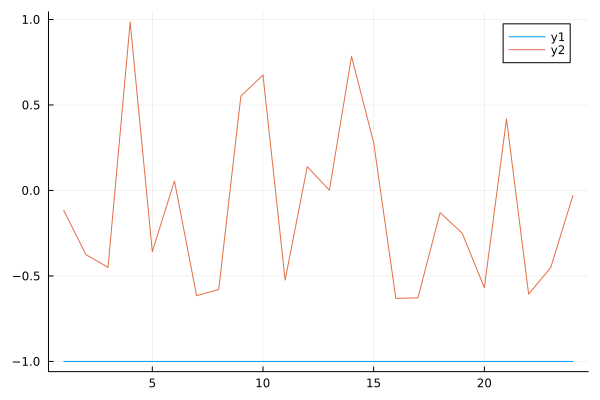

In [22]:
#time = [i for i=1:101]'
test_y_pre = model(train_x)
# print(test_y_pre)
# print(train_y)
plot([test_y_pre' , train_y'])